# Customer Churn detection 

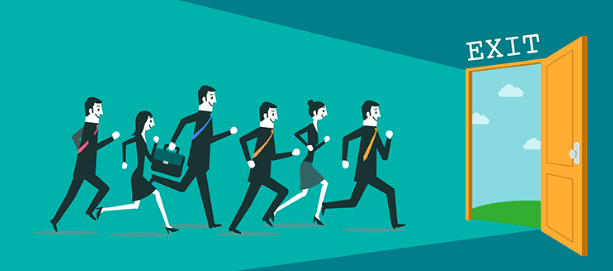

* `Import Libraries`

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import chi2, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

* `Read Dataset`

In [32]:
FILE_PATH = os.path.join(os.getcwd(), "..", "dataset", "churn-data.csv")
df = pd.read_csv(FILE_PATH)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [33]:
df.shape

(10000, 14)

In [34]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [35]:
# renaming columns
df.columns = df.columns.str.strip().str.replace(' ', '_')

In [36]:
# info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [37]:
# stats
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [38]:
# Drop first 3 features
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

* `EDA`

In [39]:
# Check nans
df.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [40]:
#check duplicates
df.duplicated().sum()

0

In [41]:
# Geography
df['Geography'].value_counts()

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

In [42]:
# Gender
df['Gender'].value_counts()

Gender
Male      5457
Female    4543
Name: count, dtype: int64

In [43]:
# Target
df['Exited'].value_counts(normalize=True)

Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64

In [44]:
df.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [45]:
# Tenure
df['Tenure'].unique()

array([ 2,  1,  8,  7,  4,  6,  3, 10,  5,  9,  0], dtype=int64)

* `Data Vizualization & Handling Outliers`

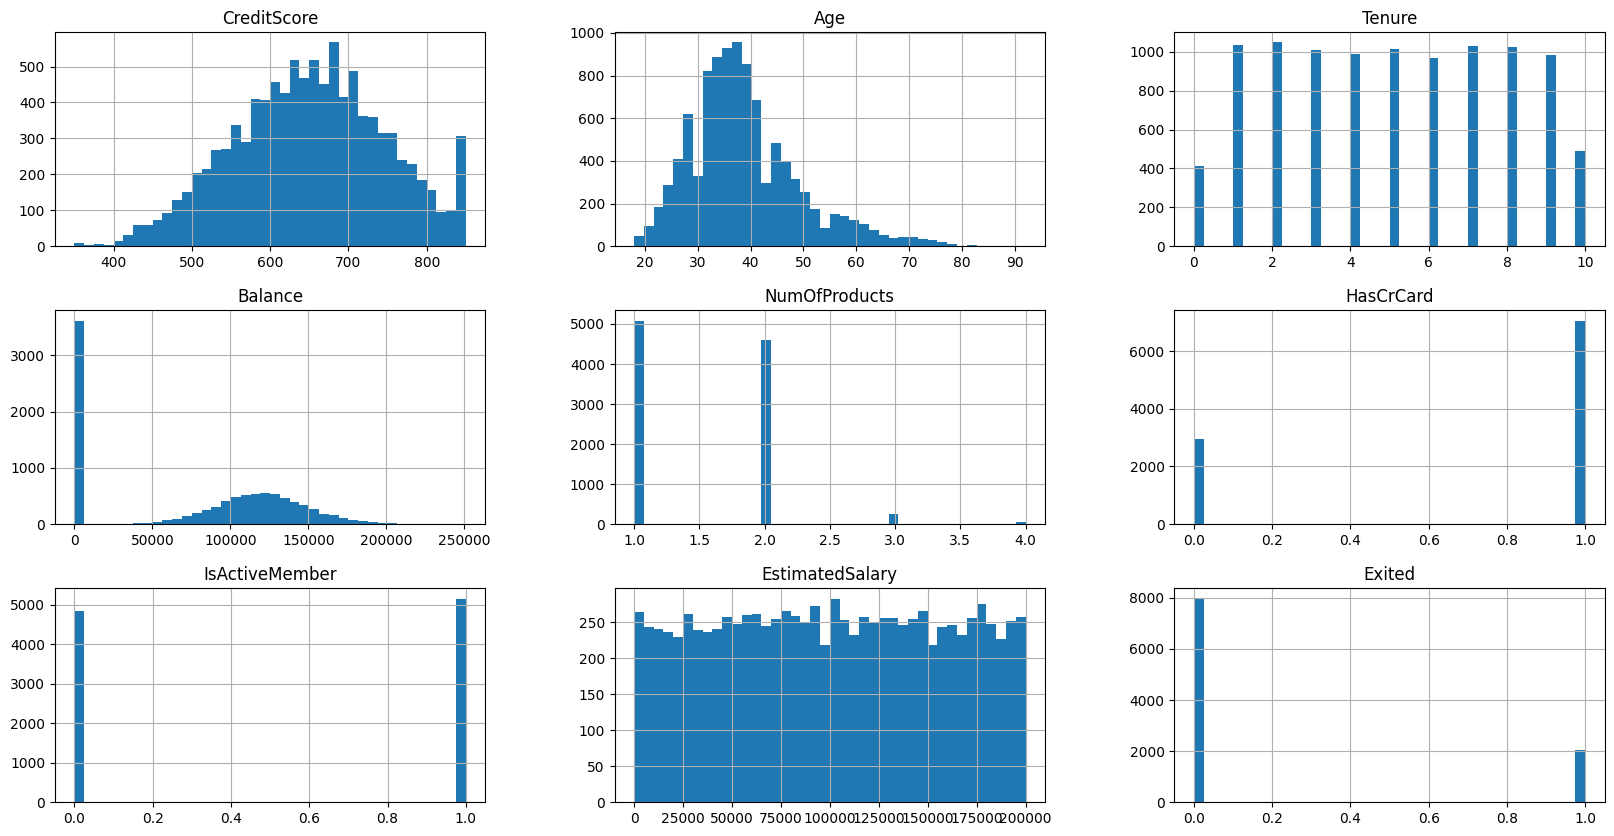

In [46]:
# Numerical hist
df.hist(bins=40, figsize=(20, 10))
plt.show()

In [47]:
print("Number of customers with Age > 80:", (df['Age'] > 80).sum())

Number of customers with Age > 80: 12


In [48]:
# drop some otuliers
df.drop(index=df[df['Age'] > 80].index.tolist(), axis=0, inplace=True)

In [49]:
df.shape

(9988, 11)

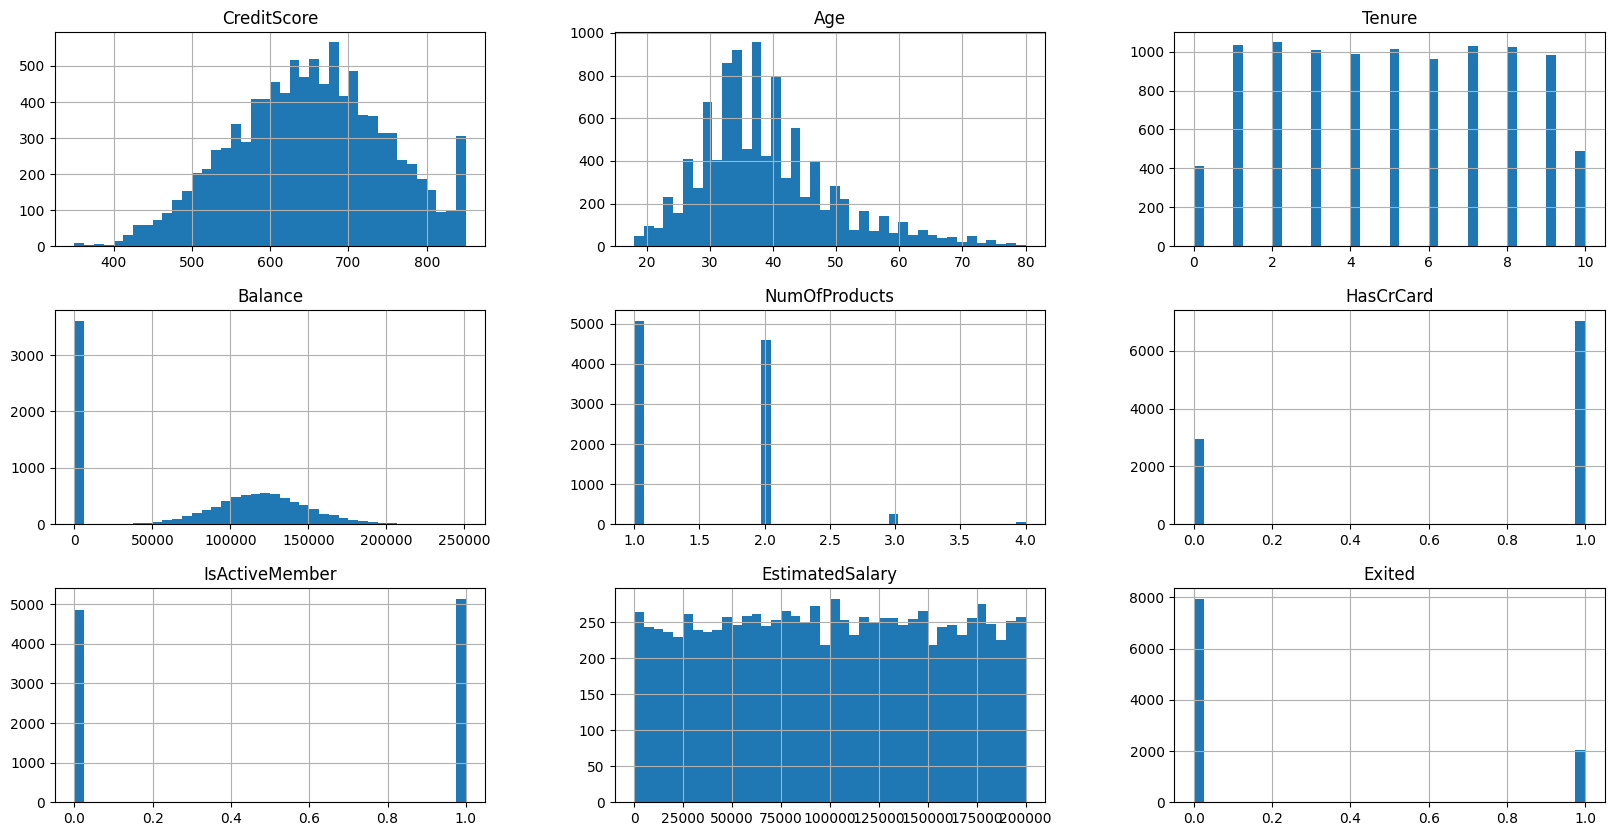

In [50]:
# After: Numerical hist
df.hist(bins=40, figsize=(20, 10))
plt.show()

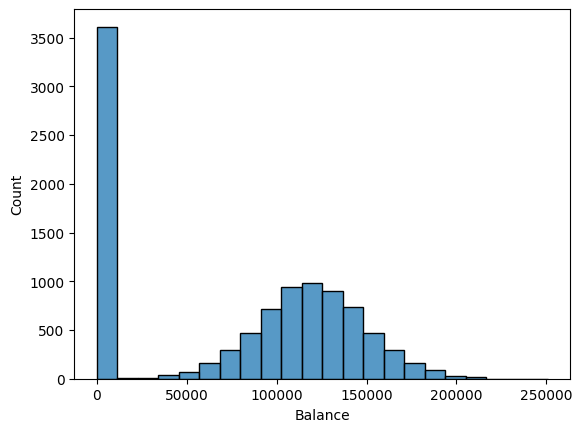

In [51]:
sns.histplot(x=df['Balance'])  
plt.show()

We can see that most of the clients have a zero balance.The balance of rest of the clients have a normal distribution

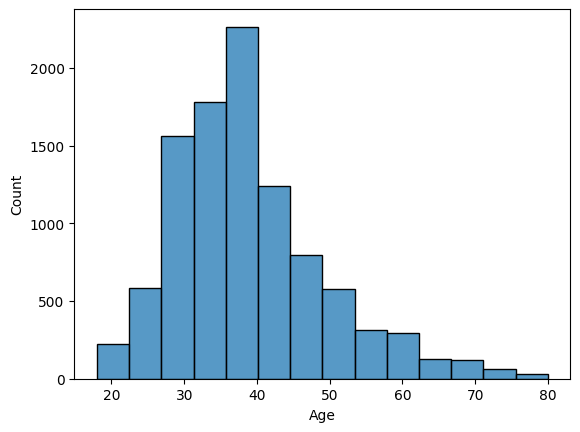

In [52]:
sns.histplot(x=df['Age'], bins =14) 
plt.show()

The age of most of the clients are between 35 and 40.

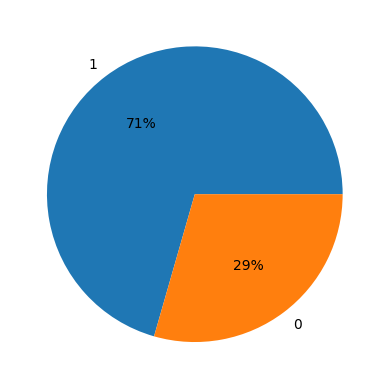

In [ ]:
data = df['HasCrCard'].value_counts()

plt.pie(data, labels=data.index, autopct='%.0f%%') 
plt.show()

majority of clients have credit cards(71%).

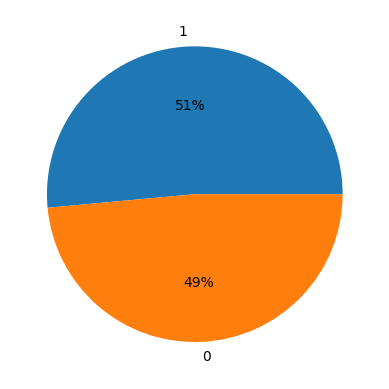

In [54]:
data = df['IsActiveMember'].value_counts()

plt.pie(data, labels=data.index, autopct='%.0f%%') 
plt.show()

51% is active member and 48% in not active member.

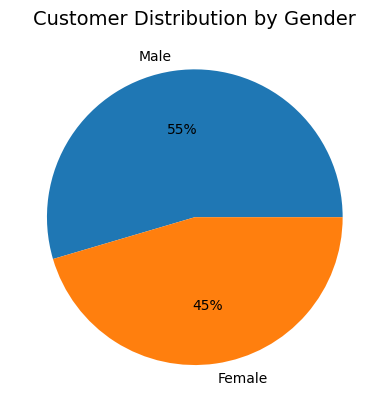

In [62]:
data = df['Gender'].value_counts()

plt.pie(data, labels=data.index, autopct='%.0f%%')
plt.title("Customer Distribution by Gender", fontsize=14)  
plt.show()

we can see that the % of male > % of female

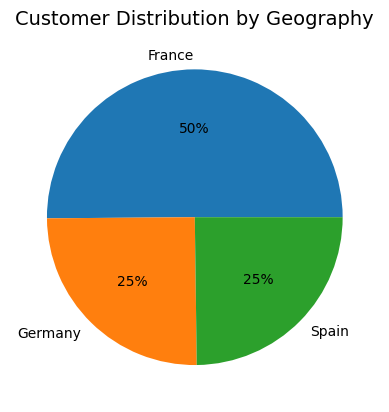

In [60]:
data = df['Geography'].value_counts()

plt.pie(data, labels=data.index, autopct='%.0f%%')
plt.title("Customer Distribution by Geography", fontsize=14)  
plt.show()

Half of the Clients are from France.Each of Spain and Germany has the quarter of clients.

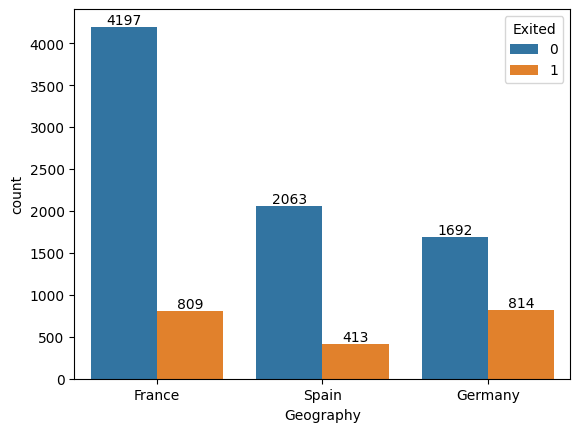

In [ ]:
chart =sns.countplot(data=df, x='Geography', hue ='Exited')  
for container in chart.containers:
        chart.bar_label(container)

plt.show()


We can see that Germany had the most number of exited clients.Spain has the lowest number of exited clients.

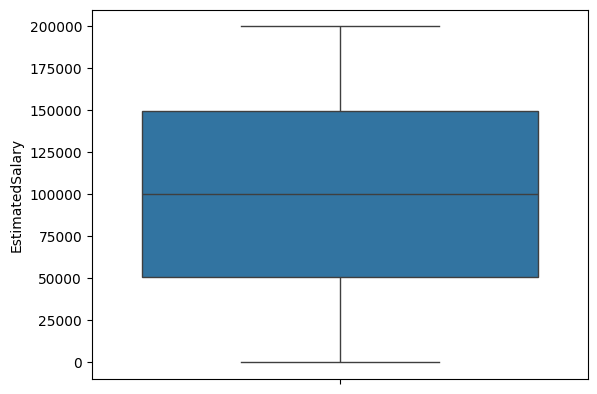

In [20]:
# Boxplot for (EstimatedSalary)
sns.boxplot(data=df, y='EstimatedSalary')
plt.show()

estimated salary has uniform distrebution and has no outlaiers

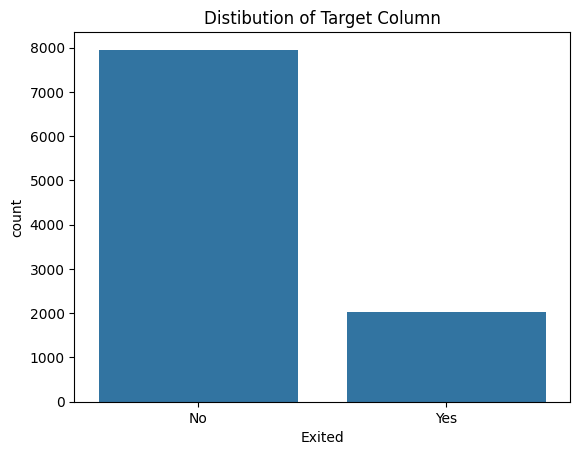

In [21]:
# countplot for Exited
sns.countplot(data=df, x='Exited')
plt.title('Distibution of Target Column')
plt.xticks(labels=["No", "Yes"], ticks=[0, 1])
plt.show()

We can see that our dataset is highly imbalanced.Most of the clients did not leave the bank.I will use techniques like SMOTE and class weight to balance my labels and will train my models with balanced data. 

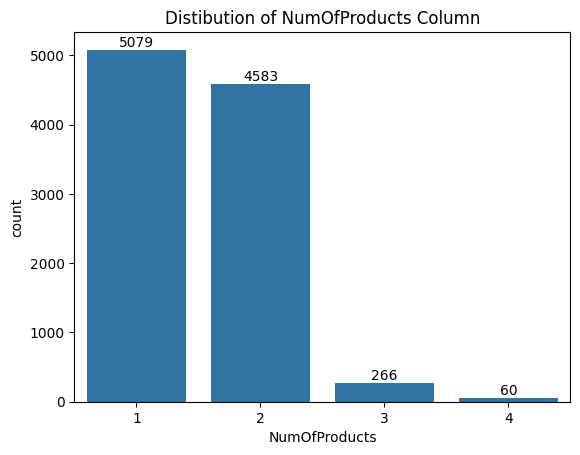

In [57]:
chart = sns.countplot(data=df, x='NumOfProducts')
for container in chart.containers:
        chart.bar_label(container)
plt.title('Distibution of NumOfProducts Column')
plt.show()

We can see from the plot that most of the clients have one product.Only 60 clients have 4 products.

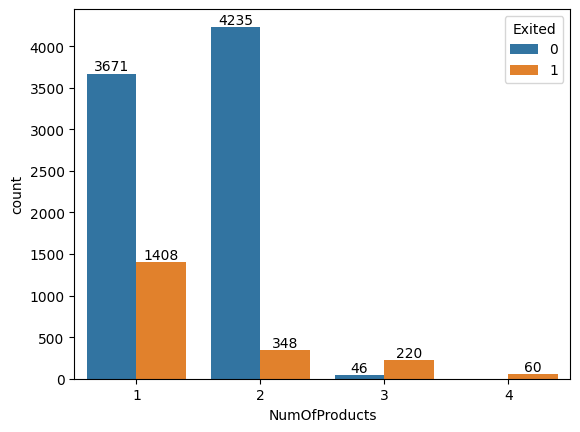

In [59]:
chart = sns.countplot(data=df, x='NumOfProducts' ,hue='Exited')
for container in chart.containers:
        chart.bar_label(container)
        
plt.show()

We can see from above plot that between those clients that have 3 or 4 products, the number of churned clients is more than stayed clients.

In [22]:
# for each gender, get the mean of estimatedsalary
df.groupby("Gender")["EstimatedSalary"].mean()

Gender
Female    100575.998277
Male       99671.901194
Name: EstimatedSalary, dtype: float64

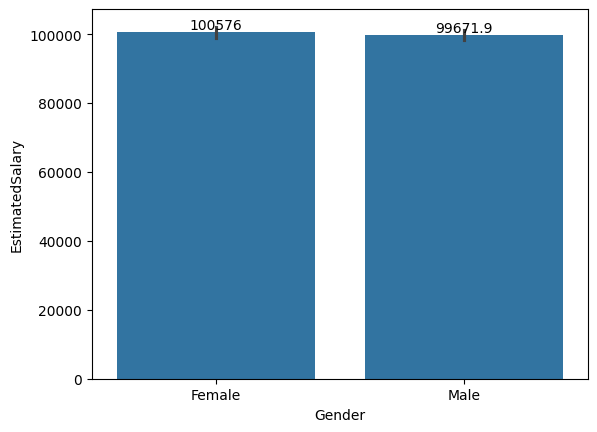

In [64]:
chart = sns.barplot(data=df, x='Gender', y="EstimatedSalary", estimator="mean")
for container in chart.containers:
        chart.bar_label(container)

plt.show()


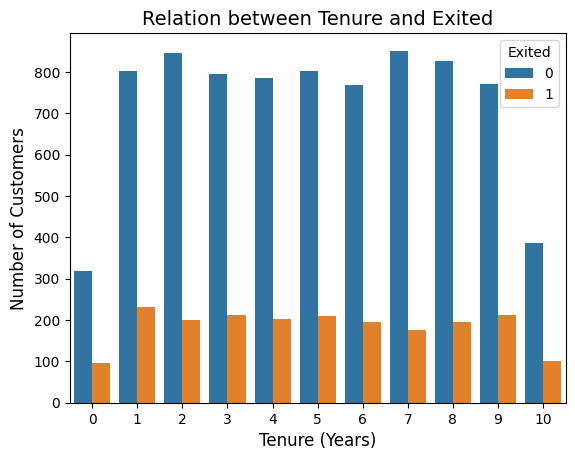

In [24]:
# Relation between Tenure and Exited
sns.countplot(data=df, x='Tenure', hue='Exited')

plt.title("Relation between Tenure and Exited", fontsize=14) 
plt.xlabel("Tenure (Years)", fontsize=12)             
plt.ylabel("Number of Customers", fontsize=12) 
plt.show()

We can observe from the above plot that those clients who has been with the bank for 2 years had the highest number of churns.

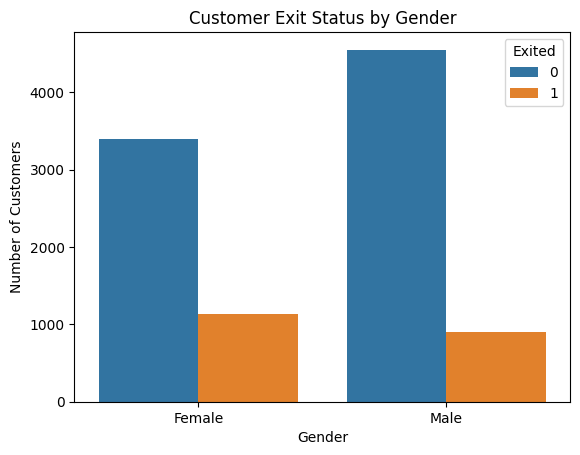

In [28]:
# Gender with Exited
sns.countplot(data=df, x='Gender', hue='Exited')
plt.title("Customer Exit Status by Gender")
plt.xlabel("Gender")
plt.ylabel("Number of Customers")
plt.show()

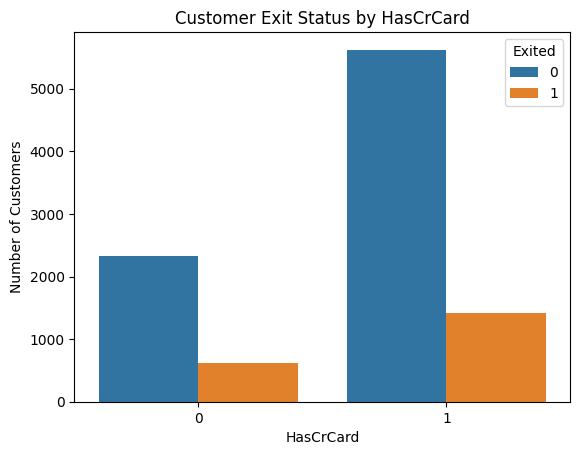

In [29]:
# HasCrCard with Exited
sns.countplot(data=df, x='HasCrCard', hue='Exited')
plt.title("Customer Exit Status by HasCrCard")
plt.xlabel("HasCrCard")
plt.ylabel("Number of Customers")
plt.show()

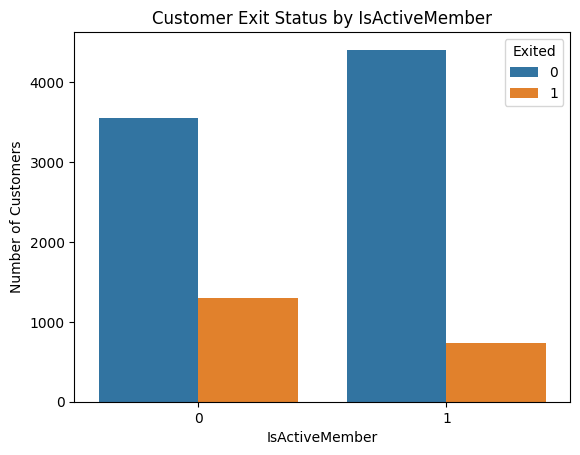

In [30]:
# IsActiveMember with Exited
sns.countplot(data=df, x='IsActiveMember', hue='Exited')
plt.title("Customer Exit Status by IsActiveMember")
plt.xlabel("IsActiveMember")
plt.ylabel("Number of Customers")
plt.show()

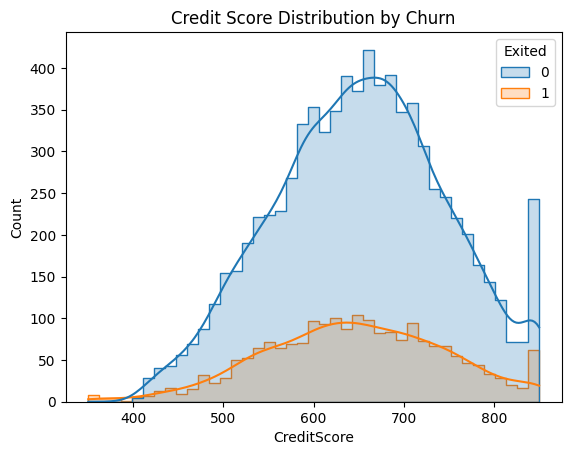

In [32]:
sns.histplot(data=df, x='CreditScore', hue='Exited', kde=True, element="step")
plt.title("Credit Score Distribution by Churn")
plt.show()

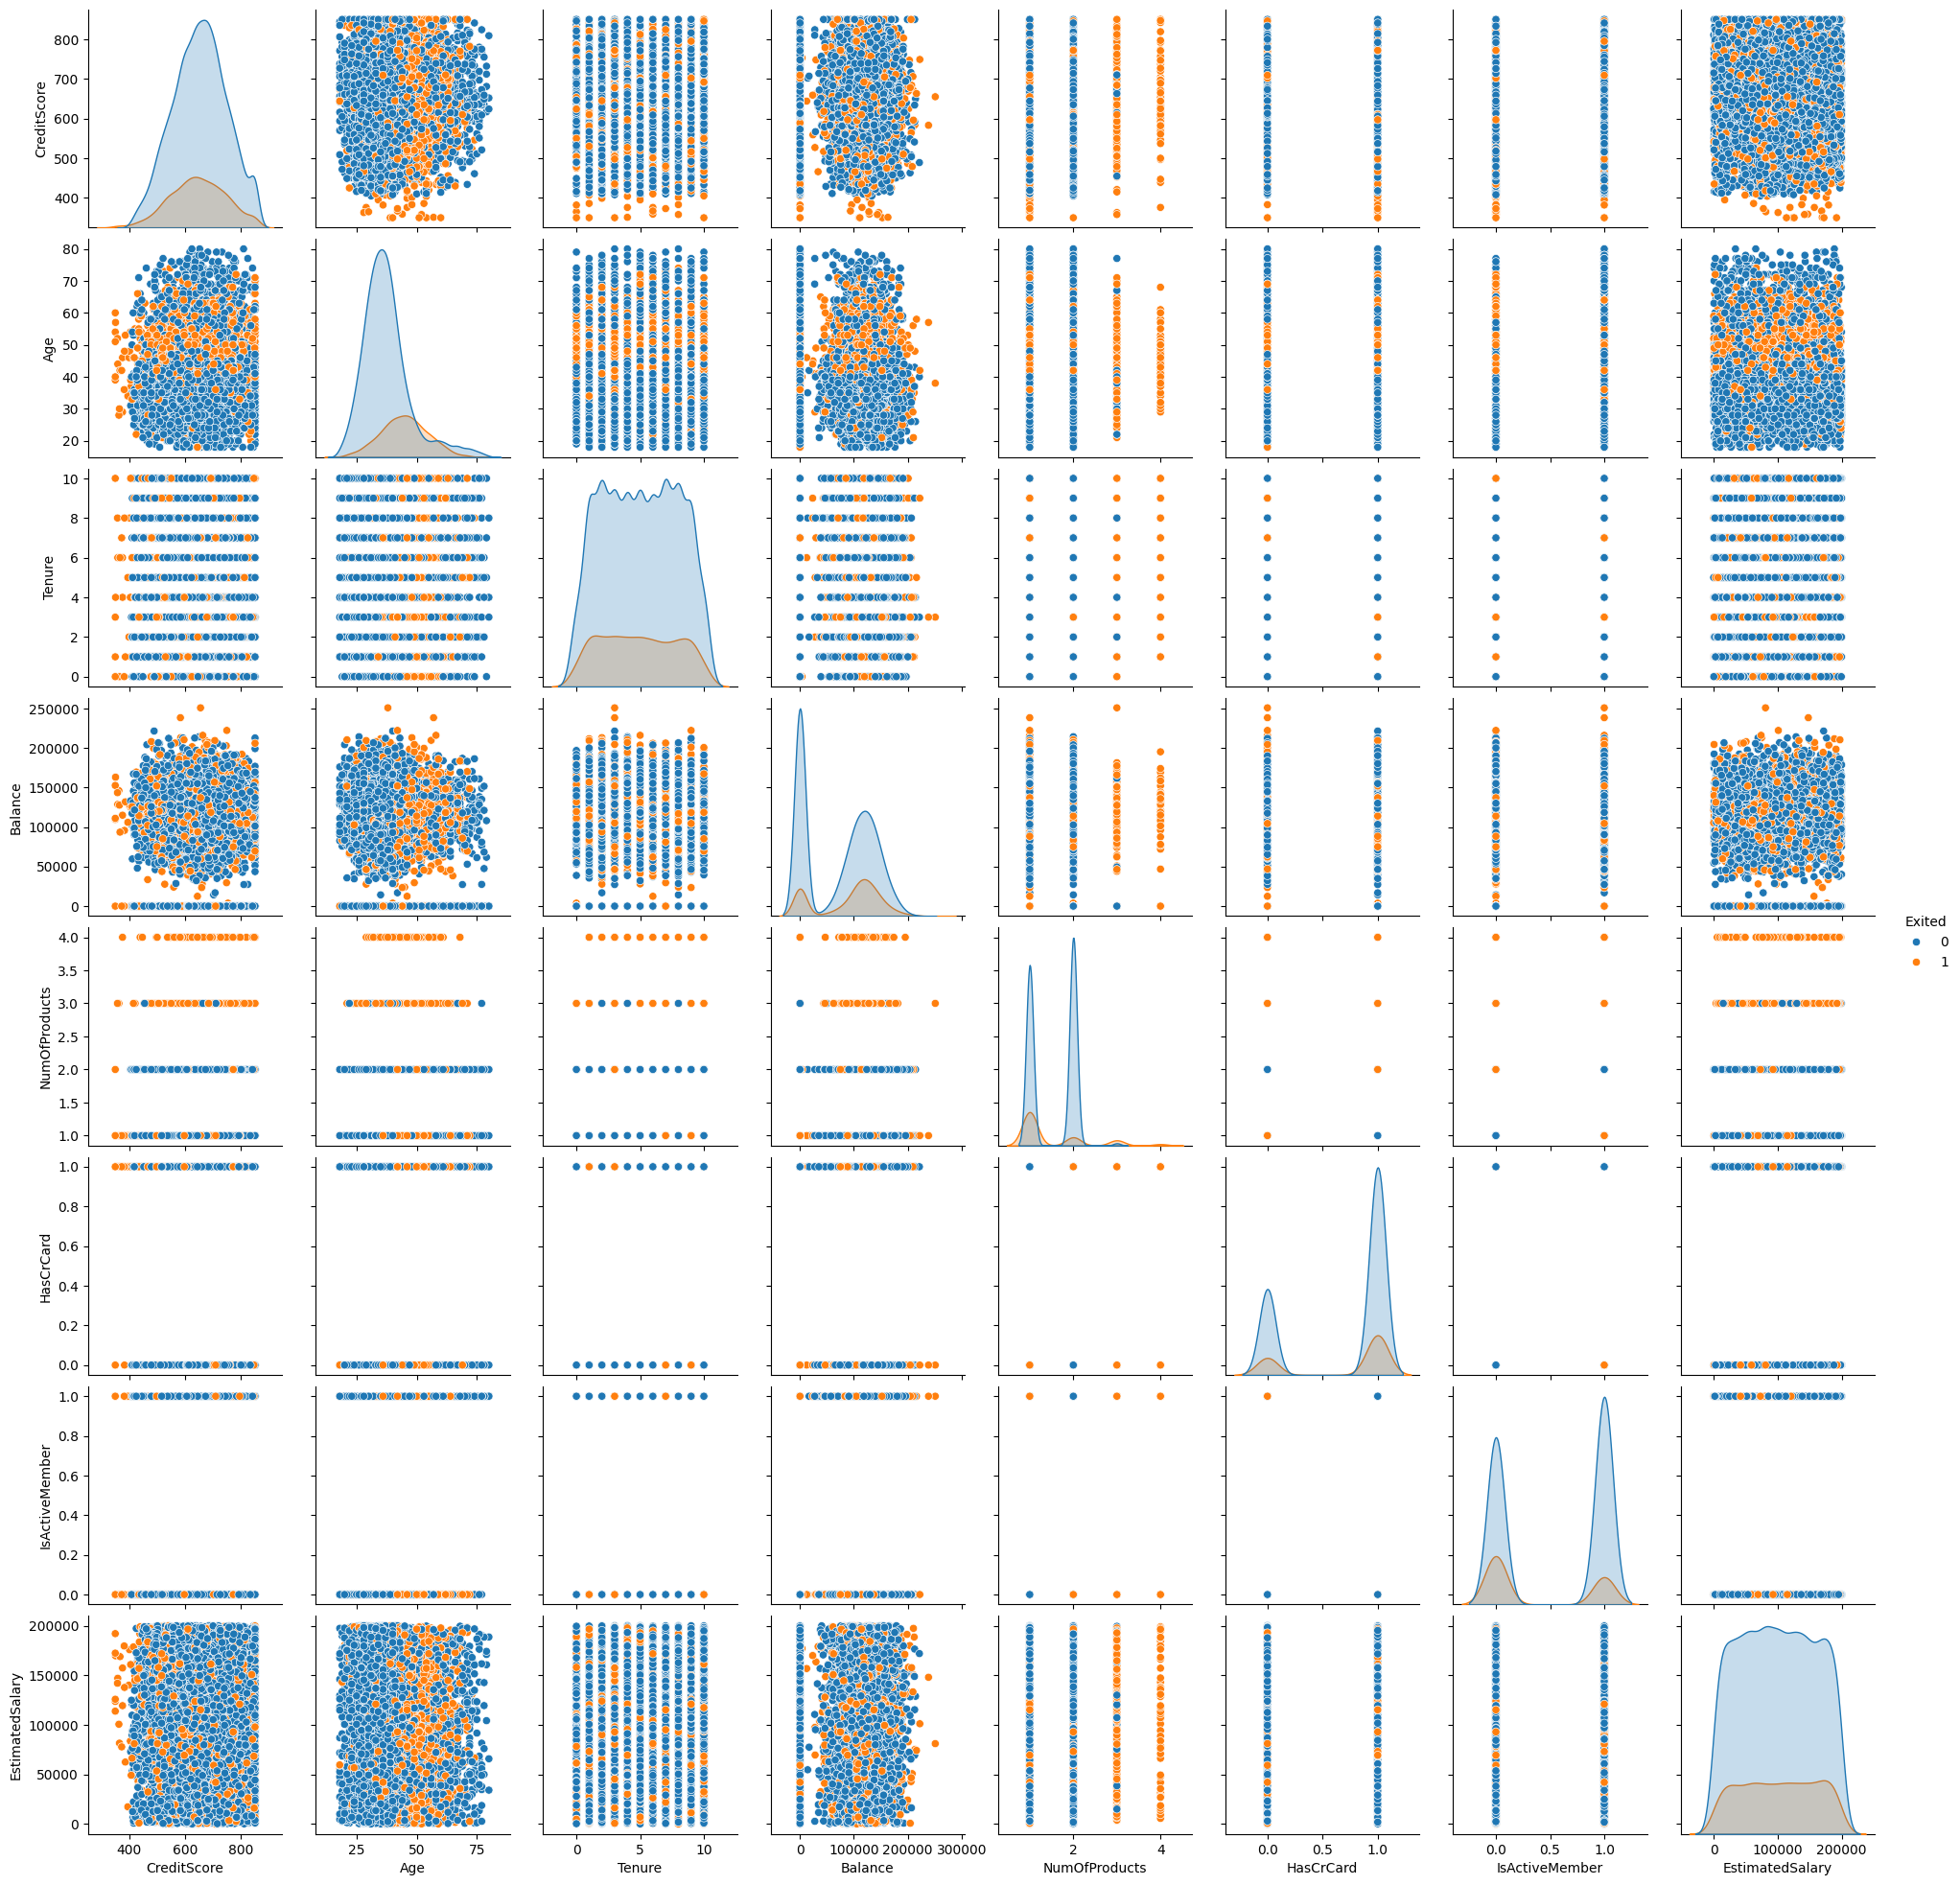

In [65]:
sns.pairplot(df, hue ='Exited')

plt.show()

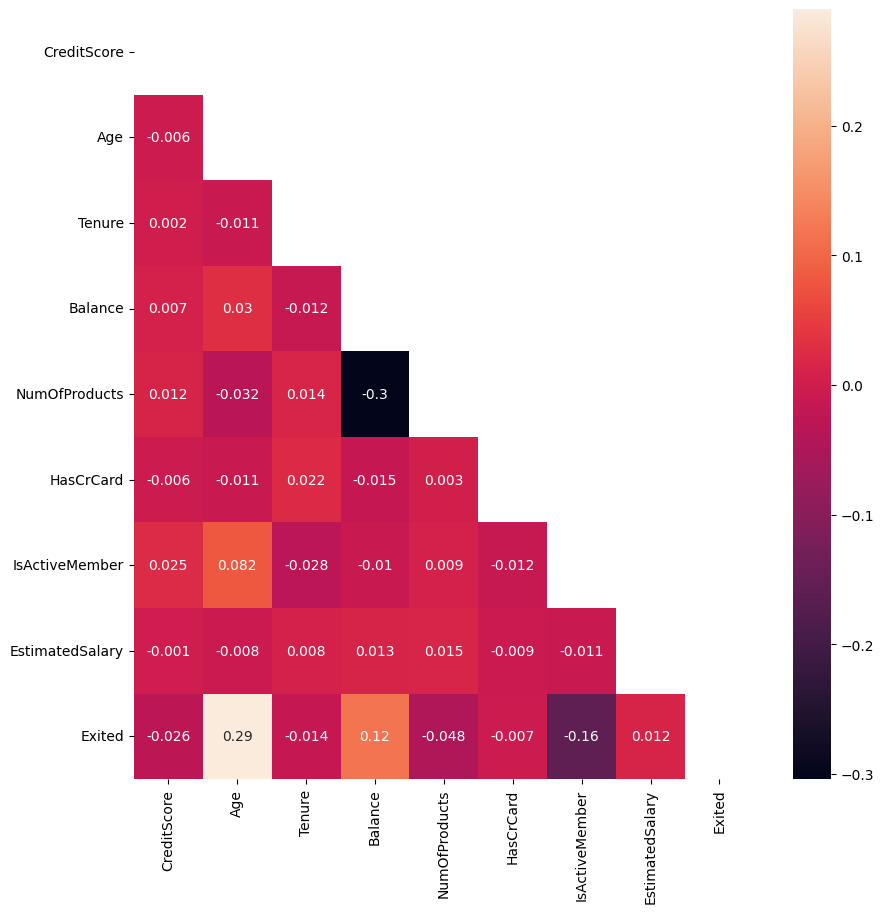

In [68]:
numeric_cols_for_heatmap = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 
                'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']

fig = plt.figure(figsize=(10,10))

matrix = np.triu(df[numeric_cols_for_heatmap].corr())
sns.heatmap(df[numeric_cols_for_heatmap].corr().round(3), mask=matrix, annot=True)
plt.show()

----

* `Split to train & test`

In [69]:
# to X & y
X = df.drop(columns=['Exited'], axis=1)
y = df['Exited']

# to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=45, stratify=y)

# Check shapes
print('X_train.shape \t', X_train.shape)
print('y_train.shape \t', y_train.shape)
print('---'*10)
print('X_test.shape \t', X_test.shape)
print('y_test.shape \t', y_test.shape)

X_train.shape 	 (7990, 10)
y_train.shape 	 (7990,)
------------------------------
X_test.shape 	 (1998, 10)
y_test.shape 	 (1998,)


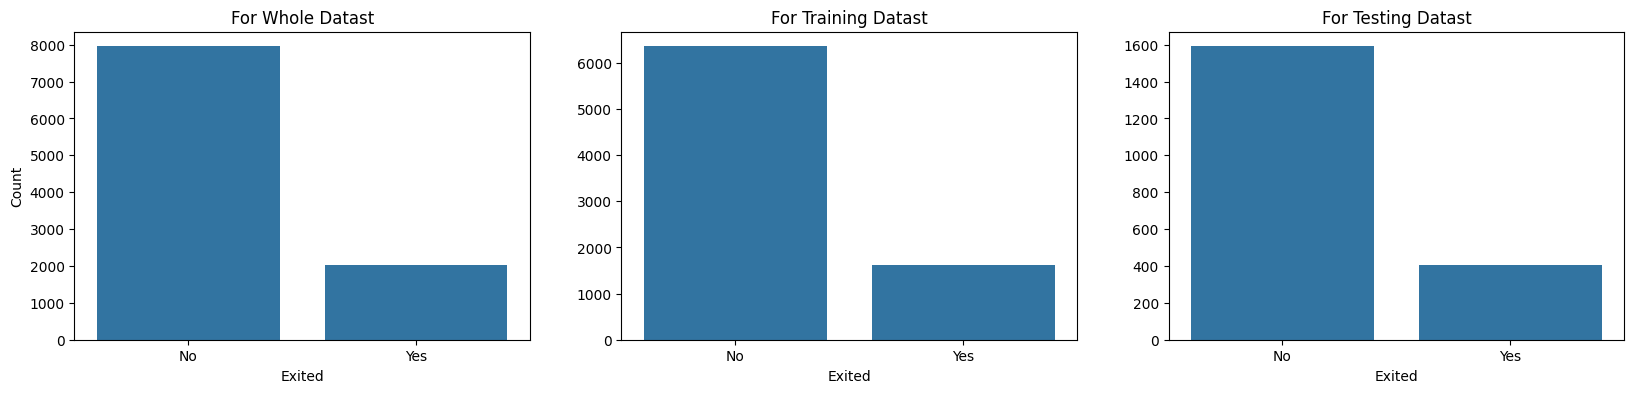

In [35]:
# plottting to check
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

# Whole dataset
plt.sca(ax[0])
sns.countplot(x=y)
plt.title('For Whole Datast')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])

# train
plt.sca(ax[1])
sns.countplot(x=y_train)
plt.title('For Training Datast')
plt.ylabel('')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])

# test
plt.sca(ax[2])
sns.countplot(x=y_test)
plt.title('For Testing Datast')
plt.ylabel('')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()

* `Feature Selection & Preprocessing`

In [70]:
# slice cols
num_cols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
categ_cols = ['Geography', 'Gender']
ready_cols = list(set(X_train.columns) - set(num_cols) - set(categ_cols))

In [71]:
ready_cols

['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

In [ ]:
# For num_cols with target --> ANOVA
# ANOVA used to measure how much a numeric feature is related to the target.
#  p_val < 0.05 → feature is statistically significant (likely useful for prediction)
#  p_val >= 0.05 → not significant (feature may not help much)
_, p_val = f_classif(X=X_train[num_cols], y=y_train)
print(p_val)
p_val>0.05 # I want to procees with all these features, so assume all p_values < 0.05 --> Recject H0 == there is an association between features and target

[9.12989970e-002 1.15359217e-149 3.56368021e-025 6.16127881e-001]


array([ True, False, False,  True])

In [75]:
# for catge_cols with target --> chi2
# Chi-Square test checks whether there is a statistical association between categorical features and the target.
# Convert categorical features into numeric form using OrdinalEncoder (chi2 requires numeric input)
_, p_val = chi2(X=OrdinalEncoder().fit_transform(X_train[categ_cols]), y=y_train)
print(p_val)
p_val>0.05  # p_value < 0.05 --> Reject H0 --> There is an association between features and target

[1.56448286e-03 5.13986341e-10]


array([False, False])

In [76]:
# for ready_cols with target --> chi2
_, p_val = chi2(X=X_train[ready_cols], y=y_train)
print(p_val)
p_val>0.05  # I want to procees with all these features, so assume all p_values < 0.05 --> Recject H0 == there is an association between features and target

[6.36015039e-02 6.55133468e-02 6.69284702e-01 7.15759804e-22]


array([ True,  True,  True, False])

In [77]:
# Pipeline

# Numerical: num_cols --> Imputing using median, and standardization
# Categorical: categ_cols --> Imputing using mode, and OHE
# Ready : read_cols --> Imputig using mode


# For Numerical
num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# For Categorical
categ_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(sparse_output=False, drop="first"))
])

# For Ready
ready_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent"))
])


# Combine all
preprocessor = ColumnTransformer(transformers=[
    ("num", num_pipeline, num_cols),
    ("categ", categ_pipeline, categ_cols),
    ("ready", ready_pipeline, ready_cols)
])

# Apply
X_train_final = preprocessor.fit_transform(X_train)
X_test_final = preprocessor.transform(X_test)

In [78]:
X_train_final.shape, y_train.shape

((7990, 11), (7990,))

In [79]:
X_test_final.shape, y_test.shape

((1998, 11), (1998,))

In [80]:
# make a folder for assets
ARTIFACT_FOLDER_PATH = os.path.join(os.getcwd(), "..", "assets")
os.makedirs(ARTIFACT_FOLDER_PATH, exist_ok=True)

In [81]:
# Dump pipeline
joblib.dump(preprocessor, os.path.join(ARTIFACT_FOLDER_PATH, "preprocessor.pkl"))

['d:\\work projects Ai track\\ChurnFullProject\\notebooks\\..\\assets\\preprocessor.pkl']

----

* `Dealing with imbalanced Data`

In [88]:
# 1. Using class_weight for solving imbalanced data
vals_count = 1 - (np.bincount(y_train) / len(y_train))
vals_count = vals_count / sum(vals_count)
dict_weights = {}
for i in range(2):  # 2 classes (0, 1)
    dict_weights[i] = vals_count[i]

# to model
dict_weights

{0: 0.20387984981226537, 1: 0.7961201501877346}

In [ ]:
# 2. Using UnderSampling or OverSampling

# Using SMOTE 
#Majority class = 0 → not exit , Minority class = 1 → exit
#sampling_strategy=0.7 → after resampling, the minority class will be 70% of the majority class
over = SMOTE(sampling_strategy=0.7, k_neighbors=5, random_state=45)
X_train_resampled, y_train_resampled = over.fit_resample(X_train_final, y_train)

counter_y_train = Counter(y_train)
print("Class distribution in y_train (before resampling):", counter_y_train)
counter_y_train_resampled = Counter(y_train_resampled)
print("Class distribution in y_train (after resampling):", counter_y_train_resampled)

Class distribution in y_train (before resampling): Counter({0: 6361, 1: 1629})
Class distribution in y_train (after resampling): Counter({0: 6361, 1: 4452})


----

* `Building Models`
> Let's consider evaluation using `f1-score`

* `LogisticRegression`

In [86]:
# Using Logistic without considering any method for solving imbalanced
log_clf = LogisticRegression(C=1.5)
log_clf.fit(X_train_final, y_train)

# Predict
y_pred_train_log = log_clf.predict(X_train_final)
y_pred_test_log = log_clf.predict(X_test_final)

# Evaluate
score_train_log = f1_score(y_train, y_pred_train_log)
score_test_log = f1_score(y_test, y_pred_test_log)

print(f'The f1_score using Logistic model for Training Dataset is {score_train_log*100:.3f}')
print(f'The f1_score using Logistic model for Testing Dataset is {score_test_log*100:.3f}')

The f1_score using Logistic model for Training Dataset is 30.965
The f1_score using Logistic model for Testing Dataset is 37.500


In [89]:
# 2. Using logisit -- using class_weight
log_clf = LogisticRegression(C=1.5, class_weight=dict_weights)
log_clf.fit(X_train_final, y_train)

# Predict and evaluate
y_pred_train_log = log_clf.predict(X_train_final)
y_pred_test_log = log_clf.predict(X_test_final)

# using f1-score
score_train_log = f1_score(y_train, y_pred_train_log)
score_test_log  = f1_score(y_test, y_pred_test_log)

print(f'The f1_score using Logistic model for Training Dataset is {score_train_log*100:.3f}')
print(f'The f1_score using Logistic model for Testing Dataset is {score_test_log*100:.3f}')

The f1_score using Logistic model for Training Dataset is 49.814
The f1_score using Logistic model for Testing Dataset is 49.915


In [93]:
# 3. Using logisit -- using SMOTE
log_clf = LogisticRegression(C=1.5)
log_clf.fit(X_train_resampled, y_train_resampled)

# Predict and evaluate
y_pred_train_log = log_clf.predict(X_train_final)
y_pred_test_log = log_clf.predict(X_test_final)

# using f1-score
score_train_log = f1_score(y_train, y_pred_train_log)
score_test_log  = f1_score(y_test, y_pred_test_log)

print(f'The f1_score using Logistic model for Training Dataset is {score_train_log*100:.3f}')
print(f'The f1_score using Logistic model for Testing Dataset is {score_test_log*100:.3f}')

The f1_score using Logistic model for Training Dataset is 49.757
The f1_score using Logistic model for Testing Dataset is 50.420


In [94]:
print(classification_report(y_test, y_pred_test_log))

              precision    recall  f1-score   support

           0       0.89      0.81      0.84      1591
           1       0.44      0.59      0.50       407

    accuracy                           0.76      1998
   macro avg       0.66      0.70      0.67      1998
weighted avg       0.79      0.76      0.78      1998



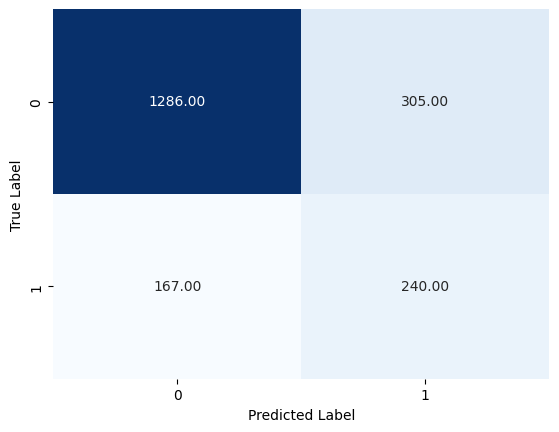

In [97]:
sns.heatmap(confusion_matrix(y_test, y_pred_test_log), annot=True, cbar=False, cmap="Blues", fmt=".2f")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

* `RandomForest`

In [103]:
# Using Rf with class_weights
forest_clf = RandomForestClassifier(n_estimators=150, max_depth=5, random_state=45, class_weight=dict_weights)
forest_clf.fit(X_train_final, y_train)

# Predict and evaluate
y_pred_train_forest = forest_clf.predict(X_train_final)
y_pred_test_foerst = forest_clf.predict(X_test_final)

# Using f1_score
score_train_forest = f1_score(y_train, y_pred_train_forest)
score_test_forest = f1_score(y_test, y_pred_test_foerst)

print(f'The f1_score using RF model for Training Dataset with class_weights is {score_train_forest*100:.3f}')
print(f'The f1_score using RF model for Testing Dataset with class_weights is {score_test_forest*100:.3f}')

The f1_score using RF model for Training Dataset with class_weights is 60.391
The f1_score using RF model for Testing Dataset with class_weights is 57.889


In [104]:
# RF with SMOTE
forest_clf = RandomForestClassifier(n_estimators=150, max_depth=5, random_state=45)
forest_clf.fit(X_train_resampled, y_train_resampled)

# Predict and evaluate
y_pred_train_forest = forest_clf.predict(X_train_final)
y_pred_test_forest = forest_clf.predict(X_test_final)

# Using f1_score
score_train_forest = f1_score(y_train, y_pred_train_forest)
score_test_forest = f1_score(y_test, y_pred_test_forest)

print(f'The f1_score using RF model for Training Dataset with SMOTE is {score_train_forest*100:.3f}')
print(f'The f1_score using RF model for Testing Dataset with SMOTE is {score_test_forest*100:.3f}')

The f1_score using RF model for Training Dataset with SMOTE is 61.538
The f1_score using RF model for Testing Dataset with SMOTE is 59.085


* `RF-Tuning`

In [105]:
forest_base_clf = RandomForestClassifier(n_estimators=150, max_depth=5, random_state=45, class_weight=dict_weights)

params_best_grid = {
        'n_estimators': np.arange(100, 450, 50),
        'max_depth': np.arange(6, 14, 2)
}
grid_search_forest = GridSearchCV(estimator=forest_base_clf, param_grid=params_best_grid, cv=5, n_jobs=-1, scoring="f1", verbose=4)
grid_search_forest.fit(X_train_final, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={0: 0.20387984981226537,
                                                            1: 0.7961201501877346},
                                              max_depth=5, n_estimators=150,
                                              random_state=45),
             n_jobs=-1,
             param_grid={'max_depth': array([ 6,  8, 10, 12]),
                         'n_estimators': array([100, 150, 200, 250, 300, 350, 400])},
             scoring='f1', verbose=4)

In [106]:
grid_search_forest.best_params_, grid_search_forest.best_score_

({'max_depth': 10, 'n_estimators': 400}, 0.6193916841517013)

In [107]:
# The forest after tuning
forest_tuned = grid_search_forest.best_estimator_

# Predict and evaluate
y_pred_train_forest_tuned = forest_tuned.predict(X_train_final)
y_pred_test_forest_tuned = forest_tuned.predict(X_test_final)

# Using f1_score
score_train_forest_tuned = f1_score(y_train, y_pred_train_forest_tuned)
score_test_forest_tuned = f1_score(y_test, y_pred_test_forest_tuned)

print(f'The f1_score using tuned RF model for Training Dataset with class_weigths is {score_train_forest_tuned*100:.3f}')
print(f'The f1_score using tuned RF model for Testing Dataset with class_weigths is {score_test_forest_tuned*100:.3f}')

The f1_score using tuned RF model for Training Dataset with class_weigths is 78.724
The f1_score using tuned RF model for Testing Dataset with class_weigths is 62.932


In [108]:
# dump forest tuned model
joblib.dump(forest_tuned, os.path.join(ARTIFACT_FOLDER_PATH, "forest_tuned.pkl"))

['d:\\work projects Ai track\\ChurnFullProject\\notebooks\\..\\assets\\forest_tuned.pkl']

In [109]:
# Feature Importance
forest_tuned.feature_importances_

array([0.07950095, 0.32419642, 0.11566024, 0.08322686, 0.04746353,
       0.00984371, 0.02132306, 0.04652853, 0.20506588, 0.01128684,
       0.05590399])

In [110]:
# Get the features out from the preprocessor
features_after = [name.split('__')[1] for name in preprocessor.get_feature_names_out()]
features_after

['CreditScore',
 'Age',
 'Balance',
 'EstimatedSalary',
 'Geography_Germany',
 'Geography_Spain',
 'Gender_Male',
 'Tenure',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember']

In [111]:
# Feature Importance from RF
forest_tuned_importance = pd.DataFrame({'feature': features_after, 
                            'importance': forest_tuned.feature_importances_}).sort_values('importance', ascending=False)
forest_tuned_importance

,feature,importance
1,Age,0.324196
8,NumOfProducts,0.205066
2,Balance,0.115660
3,EstimatedSalary,0.083227
0,CreditScore,0.079501
10,IsActiveMember,0.055904
4,Geography_Germany,0.047464
7,Tenure,0.046529
6,Gender_Male,0.021323
9,HasCrCard,0.011287


----

* `XGBOOST`

In [113]:
xgb_base_model = xgb.XGBClassifier(objective="binary:logistic", n_estimators=150, 
                                max_depth=5, random_state=42, learning_rate=0.1)
xgb_base_model.fit(X_train_final, y_train)

# Predict and evaluate
y_pred_train_xgb = xgb_base_model.predict(X_train_final)
y_pred_test_xgb = xgb_base_model.predict(X_test_final)

# Using f1_score
score_train_xgb = f1_score(y_train, y_pred_train_xgb)
score_test_xgb = f1_score(y_test, y_pred_test_xgb)

print(f'The f1_score using XGBoost model for Training Dataset with scale is {score_train_xgb*100:.3f}')
print(f'The f1_score using XGBoost model for Testing Dataset with scale is {score_test_xgb*100:.3f}')

The f1_score using XGBoost model for Training Dataset with scale is 70.484
The f1_score using XGBoost model for Testing Dataset with scale is 60.266


In [114]:
# 1. Using scale_pos_weight
scale = sum(y_train==0) / sum(y_train==1)

# 2. Using sample_weight while fitting
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = class_weights / np.sum(class_weights)
weight_dict = dict(zip(np.unique(y_train), class_weights))
samples_weights = np.array([weight_dict[y] for y in y_train])
samples_weights

array([0.20387985, 0.20387985, 0.20387985, ..., 0.20387985, 0.20387985,
       0.79612015])

* `XGBoost-Tuning using RanomizedSearchCV`

In [115]:
xgb_base_model = xgb.XGBClassifier(objective='binary:logistic', max_depth=5, reg_lambda=5,
                                learning_rate=0.1, n_estimators=150, random_state=4)

# Hyperparameter tuning with class weights
param_dist = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'n_estimators': [100, 200, 300, 400],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
}

random_search_xgb = RandomizedSearchCV(estimator=xgb_base_model, 
                                    param_distributions=param_dist, 
                                    cv=5, n_jobs=-1, n_iter=25, scoring="f1", random_state=48)
random_search_xgb.fit(X_train_final, y_train, sample_weight=samples_weights)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           multi_strategy=None,
                                           n_estimators=150, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=4, ...),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8,
                                                             0.9],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.3],
                                        'max_depth': [3, 4, 5, 6, 7, 8],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 200, 300, 400],
                                        'subsample': [0.6, 0.7, 0.8, 0.9]},
                   random_state=48, scoring='f1')

In [116]:
# The xgb after tuning
xgb_tuned = random_search_xgb.best_estimator_

# Predict and evaluate
y_pred_train_xgboost_tuned = xgb_tuned.predict(X_train_final)
y_pred_test_xgboost_tuned = xgb_tuned.predict(X_test_final)

# Using f1_score
score_train_xgb_tuned = f1_score(y_train, y_pred_train_xgboost_tuned)
score_test_xgb_tuned = f1_score(y_test, y_pred_test_xgboost_tuned)

print(f'The f1_score using tuned XGBoost model for Training Dataset with scale is {score_train_xgb_tuned*100:.3f}')
print(f'The f1_score using tuned XGBoost model for Testing Dataset with scale is {score_test_xgb_tuned*100:.3f}')

The f1_score using tuned XGBoost model for Training Dataset with scale is 75.491
The f1_score using tuned XGBoost model for Testing Dataset with scale is 61.668


In [117]:
# Dump model
joblib.dump(xgb_tuned, os.path.join(ARTIFACT_FOLDER_PATH, 'xgb_tuned.pkl'))

['d:\\work projects Ai track\\ChurnFullProject\\notebooks\\..\\assets\\xgb_tuned.pkl']